# Billboard Top 100 Data Story

_James Parks_

# 1. Introduction

 We consider the Billboard Top 100 dataset, which contains the Top 100 tracks ranked by popularity for every week between September 8, 1958 and January 8, 2017. We combine this dataset with the Spotify track metadata for the songs in this dataset. The metadata contains such varaibles as song key, tempo, time signature as well as other metrics scaled between 0 and 1 like song "danceability" and "energy". Furthermore we also obtain the lyrics for the songs in the dataset. The goal with this project is to attempt to predict a song's popularity in the charts based on these features.

# 2. Library Imports

In [1]:
#Usual Imports
import time
from time import sleep
import datetime
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Imports for web scraping Lyrics data
from bs4 import BeautifulSoup
import urllib
import requests
# Imports for sentiment analysis
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

C:\Users\MSI_USER\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# 3. Datasets 
We load the Billboard Top 100 dataset and Spotify metadata from Decibels & Decimals https://github.com/dbfowler/billboard_volatility/tree/master/Raw%20Data. We load the lyric dataset that we previously scraped from various websites. (We descrbe the lyric scraping procedure in Section 5.)

In [2]:
billboard_data = pd.read_csv("all_charts.csv")
spotify_data = pd.read_csv("audio_features.csv")
billboard_lyrics = pd.read_csv("all_lyrics.csv",encoding='latin1')

C:\Users\MSI_USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (18,19,20,21,22,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# 4. Prepare a Tidy Dataset
We first combine the Billboard Top 100 and Spotify data together.

For this project the variables we are interested in are: chartDate, title, artist, peakPos, lastPos, weeks, rank, change and spotifyLink from billboard_data and the acousticness, danceability, duration_ms, energy, id, instrumentalness, key, liveness, loudness, mode, speechiness, tempo, time_signature and valence variables from spotify_data.

In [3]:
billboard_sub = billboard_data[["chartDate","title","artist","peakPos","lastPos","weeks","rank","change","spotifyID"]]
spotify_sub = spotify_data[["acousticness", "danceability", "duration_ms", "energy", "id","instrumentalness", "key", "liveness", "loudness", "mode", "speechiness", "tempo", "time_signature","valence"]]

We now merge the billboard and spotify datasets together by their spotifyID and id variables respectively.

In [4]:
merged_data=pd.merge(billboard_sub,spotify_sub, how="outer",left_on="spotifyID",right_on="id")
#Replace weird characters:
merged_data=merged_data.replace({'\x83': '?'}, regex=True).replace({'\x82': '?'}, regex=True).replace({'\x80\x9c': '??'}, regex=True)

Next we merge the merged dataset above with the lyrics dataset.
We first subset the lyrics data by only the artist, lyrics, source and track variables.

In [5]:
lyrics_sub=billboard_lyrics[["artist","lyrics","track","source"]]
big_dataset=pd.merge(merged_data, lyrics_sub,  how="outer",left_on=["artist","title"],right_on=["artist", "track"])

# 5. Lyric Scraping Step
We describe the steps taken to obtain the billboard_lyrics dataframe.
First we created a subset of individual tracks from the merged_data dataframe by subsetting by the "title" and "artist" variables.

In [6]:
search_data=merged_data.groupby(["title","artist"]).size().reset_index()

In [7]:
len(search_data)

27588

We have 27588 individuals tracks in the Billboard TOp 100 that we must cycle through. From the artist and track name for each track we created different "typical" lyrics urls from a variety of lyric websites to attempt to extract the lyrics using the beautiful soup python library.

Since this process was quite time consuming we broke up the lyrics dataframes into several different files.

In [ ]:
lyrics_data = pd.DataFrame()
lower_limit =0
upper_limit =27588
# Our lyrics dataset files have the following format:
lyrics_table = 'lyrics-' +str(lower_limit)+"-"+ str(upper_limit)+'.csv'
start = time.time()
for row in range(lower_limit,upper_limit):
    artist_raw = search_data.iloc[row,1]
    artist_noand=artist_raw.replace(" &","").replace(". ","-").replace("Ã©","e").replace("$", "s")
    # We only consider the first listed artist.
    artist_array = re.split(r'.Featuring+', artist_noand) 
    track_raw=search_data.iloc[row,0]
    # We replace extended latin characters that caused errors when trying to make website requests.
    track_name=track_raw.replace("Ã\x83Â¶","oe").replace("Ã©","e").replace("ÃÂ©","e").replace("ÃÂ³",'o')
    track_name=track_name.replace("ÃÂ¡","a").replace("ÃÂ±","n").replace("Ã\x83â\x80\x9c","o").replace("ÃÂ¿DÃÂ²","do").replace("ÃÂ","a")
    track_name=re.sub(r'\&\s', '', track_name).replace("$", "s").replace("#","")
    track_name=re.sub(r'S\*\*t', 'Shit',track_name) # Replace profanity
    # Remove special characters that don't show up in website urls.
    track_name=re.sub(r'\(|\)|\'|\|\.|\"|\,', '',track_name).lower() 
    # We now try to scrape five different lyrics sites using predictable urls based on the artist and track names.
    artist_first_letter=artist_array[0][0]
    # The formatting for lyricsmode.com 
    artist_mode = re.sub(r'\s|\.|-', '_',artist_array[0]).replace(",","").lower()
    track_mode = re.sub(r'\s', '_',track_name)
    # The track formatting for songlyrics.com and metrolyrics.com is the same.
    # The artist formatting is different if the band starts with "The ".
    artist_song = re.sub(r'\s|\.', '-',artist_array[0]).replace(",","").lower()
    track_songmetro = re.sub(r'\s', '-',track_name)
    track_az = re.sub(r'\s', '',track_name)  # The track formatting for azlyrics.com
    artist_mmatch = re.sub(r'.And', '',artist_array[0]) # The artist formatting for musixmatch.com
    artist_mmatch = re.sub(r'\s|\.', '-',artist_mmatch).replace(",","").lower()
    # The urls for bands that start with "The " are formatted differently.
    if artist_array[0].startswith("The "):
        the_array = re.split(r'The ',artist_array[0])
        artist_az = re.sub(r'\'|\s|\.|-|\,', '',the_array[1]).lower()
        artist_metro = re.sub(r'\.', '-',the_array[1]).replace(",","").replace(" ","-").lower()
    else:
        artist_az = re.sub(r'\'|\s|\.|-|\,', '',artist_array[0]).lower()
        artist_metro=artist_song
    # metrolyrics.com is inconsistent in whether it keeps "The " in the url so we have two possibilities.    
    url_metro_one = 'http://www.metrolyrics.com/'+track_songmetro+'-lyrics-'+artist_metro+'.html'
    url_metro_two = 'http://www.metrolyrics.com/'+track_songmetro+'-lyrics-'+artist_song+'.html'
    url_songlyrics = 'http://www.songlyrics.com/'+artist_song+'/'+track_songmetro+'-lyrics/'
    url_mode= 'http://www.lyricsmode.com/lyrics/'+artist_first_letter+'/'+artist_mode+'/'+track_mode+'.html'
    url_music_match = 'https://www.musixmatch.com/lyrics/' + artist_mmatch + '/' + track_songmetro
    url_azlyrics="http://www.azlyrics.com/lyrics/"+artist_az+"/"+track_az+".html"
    # These are our list of lyric urls and the hypothetical location of the lyrics text on the websites.
    URLS=[url_metro_one,url_metro_two,url_songlyrics,url_mode, url_azlyrics, url_music_match]
    lyriclocations = ['lyrics-body-text', 'lyrics-body-text','songLyricsDiv','lyrics_text',"azlyrics",'mmatch']
    choice =""
    for u in range(0,len(URLS)):
        # We now cycle through each possbile url until we get a match.
        # We then scrape the lyric text from the website using beautiful soup.
        lyrics_request = urllib.request.Request(URLS[u],headers={'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; WOW64; rv:52.0) Gecko/20100101 Firefox/52.0'})
        try:
            lyrics_web = urllib.request.urlopen(lyrics_request)
            lyrics_code = lyrics_web.read()
            soup = BeautifulSoup(lyrics_code, 'html.parser')
            if u==4:
                lyrics_array = soup.find_all("div", class_="")
            elif u == 5:
                lyrics_array = soup.find_all(class_="mxm-lyrics__content")
            else:
                lyrics_array = soup.find_all(id=lyriclocations[u])
            lyrics_text=""
            for lyrics in lyrics_array:
                lyrics_text += lyrics.get_text()
            # Some websites exist with no lyrics where the text is "\r\n ", "\r\r\n ", "\r\r\r\n ", or "\r\r\r\r\n " or "\n".
            if lyrics_text != "" and lyrics_text != "\r\n " and lyrics_text != "\n" and lyrics_text != "\r\r\n " and lyrics_text != "\r\r\r\n " and lyrics_text != "\r\r\r\r\n ":
                choice=u
                break
        except urllib.request.HTTPError as e:
            lyrics_text=""
            pass        
    add_frame = {"artist":artist_raw, "track": track_raw, "lyrics":lyrics_text, "source":choice}
    lyrics_data = lyrics_data.append(add_frame,ignore_index=True)
    # In order to not overwhelm the websites we have a delay of 45 seconds every 50 requests.
    if row%50==0 and row!=lower_limit and row!=upper_limit:
        sleep(45)
delta = time.time() - start
print ("features retrieved in %.2f seconds" % (delta,))
lyrics_data.to_csv(lyrics_table)

Now that we have several files we must join them all together. 

In [ ]:
lyrics_all=pd.DataFrame()
lyrics_one = pd.read_csv('lyrics-0-100.csv',  encoding='latin1')
lyrics_two = pd.read_csv('lyrics-100-1000.csv',  encoding='latin1')
lyrics_all = pd.concat([lyrics_one,lyrics_two])
lyrics_new = pd.read_csv('lyrics-1000-1096.csv',  encoding='latin1')
lyrics_all = pd.concat([lyrics_all,lyrics_new])
# There are several more to join here until:
lyrics_new=pd.read_csv('lyrics-27587-27588.csv',encoding='latin1')
lyrics_all = pd.concat([lyrics_all,lyrics_new])

We then obtain the complete lyric dataset we imported in section 3.

In [ ]:
lyrics_merge=lyrics_all[["artist","lyrics","source","track"]].reset_index()
lyrics_merge.to_csv('all_lyrics.csv')

# 6. Exploratory Data Analysis on the Spotify Metadata Audio Features

In [8]:
big_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304643 entries, 0 to 304642
Data columns (total 26 columns):
chartDate           304643 non-null object
title               304643 non-null object
artist              304643 non-null object
peakPos             304643 non-null int64
lastPos             304643 non-null int64
weeks               304643 non-null int64
rank                304643 non-null int64
change              304643 non-null object
spotifyID           258820 non-null object
acousticness        258820 non-null float64
danceability        258808 non-null float64
duration_ms         258820 non-null float64
energy              258820 non-null float64
id                  258820 non-null object
instrumentalness    258820 non-null float64
key                 258820 non-null float64
liveness            258820 non-null float64
loudness            258820 non-null float64
mode                258820 non-null float64
speechiness         258808 non-null float64
tempo               258

** Number of weeks in the dataset **

In [9]:
len(big_dataset.groupby("chartDate").count())

3048

** How many songs have Spotify metadata? **

In [10]:
len(spotify_data)/len(search_data)*100

78.33478323908946

** We now plot histograms of several of the Spotify metadata features. **

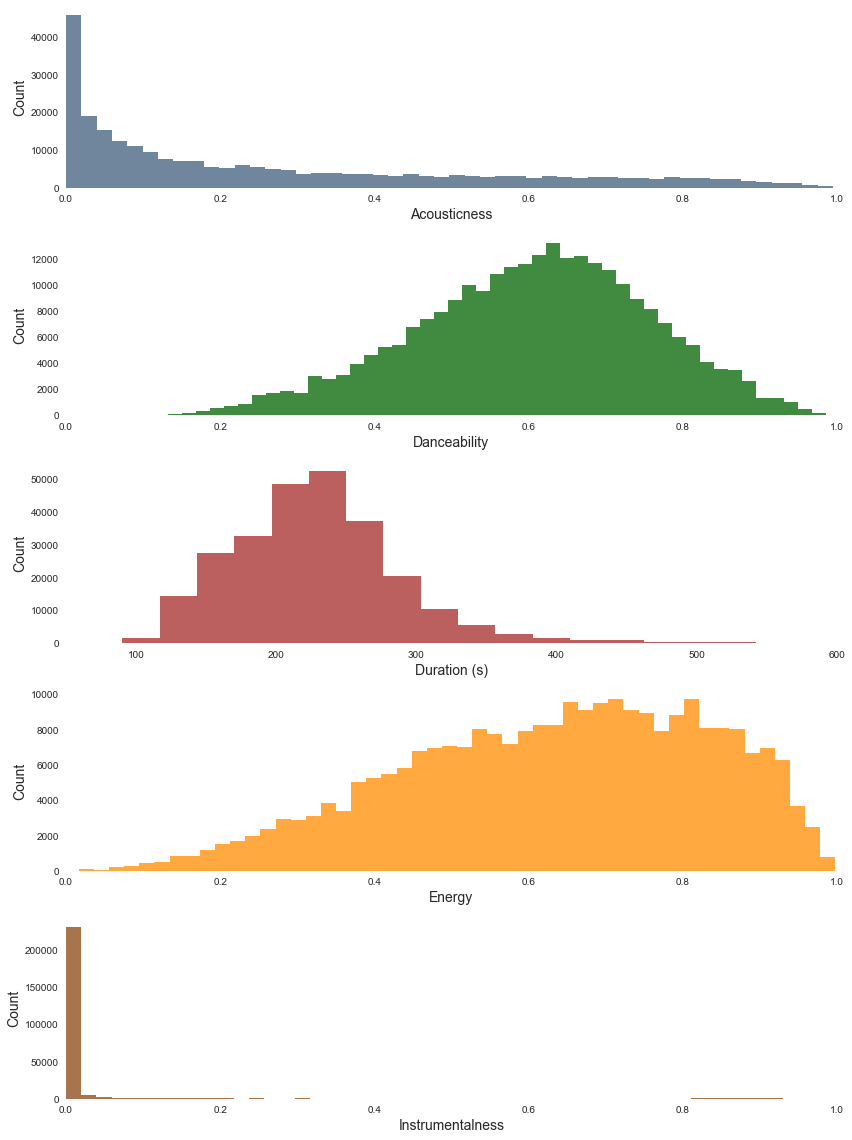

In [12]:
fig = plt.figure(figsize=(12, 16))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.hist(big_dataset.acousticness.dropna(), color="#3F5D7D", bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Acousticness", fontsize=14)
plt.ylabel('Count', fontsize=14)

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.xlim(0,1)
plt.hist(big_dataset.danceability.dropna(), color="#006400", bins=50,alpha=0.75)
plt.xlabel("Danceability", fontsize=14)
plt.ylabel('Count', fontsize=14)

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.hist(big_dataset.duration_ms.dropna()/1000, color="#a52a2a", bins=50,alpha=0.75)
plt.xlim(50,600)
plt.xlabel("Duration (s)", fontsize=14)
plt.ylabel('Count', fontsize=14)


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.hist(big_dataset.energy.dropna(), color="#ff8c00",bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Energy", fontsize=14)
plt.ylabel('Count', fontsize=14)

axfive=plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.hist(big_dataset.instrumentalness.dropna(), color="#8b4513",bins=50,alpha=0.75)
plt.xlabel("Instrumentalness", fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(0,1)
plt.tight_layout()
plt.savefig("metadata_histograms.png", bbox_inches="tight"); 
plt.show()


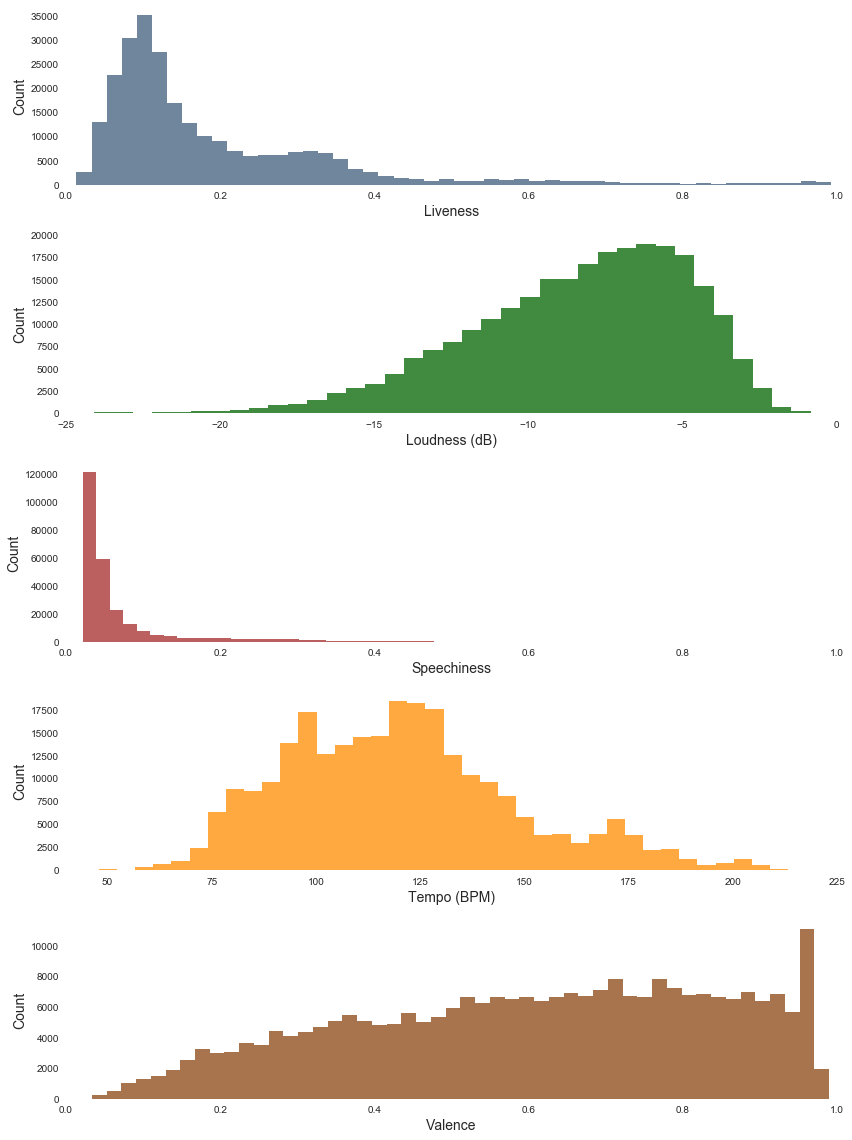

In [13]:
fig = plt.figure(figsize=(12, 16))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.hist(big_dataset.liveness.dropna(), color="#3F5D7D", bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Liveness", fontsize=14)
plt.ylabel('Count', fontsize=14)

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.xlim(-25,0)
plt.hist(big_dataset.loudness.dropna(), color="#006400", bins=50,alpha=0.75)
plt.xlabel("Loudness (dB)", fontsize=14)
plt.ylabel('Count', fontsize=14)

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.hist(big_dataset.speechiness.dropna(), color="#a52a2a", bins=50,alpha=0.75)
plt.xlim(0,1)
plt.xlabel("Speechiness", fontsize=14)
plt.ylabel('Count', fontsize=14)


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.hist(big_dataset.tempo.dropna(), color="#ff8c00",bins=50,alpha=0.75)
plt.xlim(40,225)
plt.xlabel("Tempo (BPM)", fontsize=14)
plt.ylabel('Count', fontsize=14)

axfive=plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.hist(big_dataset.valence.dropna(), color="#8b4513",bins=50,alpha=0.75)
plt.xlabel("Valence", fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xlim(0,1)
plt.tight_layout()
plt.savefig("metadata_histograms_2.png", bbox_inches="tight"); 
plt.show()



** Things of Note:**

It appears that most songs have very low acousticness, instrumentalness and speechiness values, whereas danceability, energy and tempo seems to be more normally distributed. It would make sense that the latter features would be closely related since songs with more energy and a faster tempo are easier to dance up to a point. Notice that the presence of a few very long songs in the dataset are heavily influencing the histogram. 

** What about the average of these metadata features over time?**

We first make a year column to make the trends easier to observe. We then subset so that we only consider the first week that the song entered the chart. 

In [14]:
year = big_dataset.chartDate.replace({'-': ''}, regex=True)
year = year.apply(np.float)
year = year//10000
pd.set_option('precision', 0)
year=year.rename("year")
year_data=pd.concat([big_dataset,year],axis=1)
year_data_sub=year_data[year_data.lastPos==0]
audio_means=year_data_sub.groupby(["year"]).mean().reset_index()

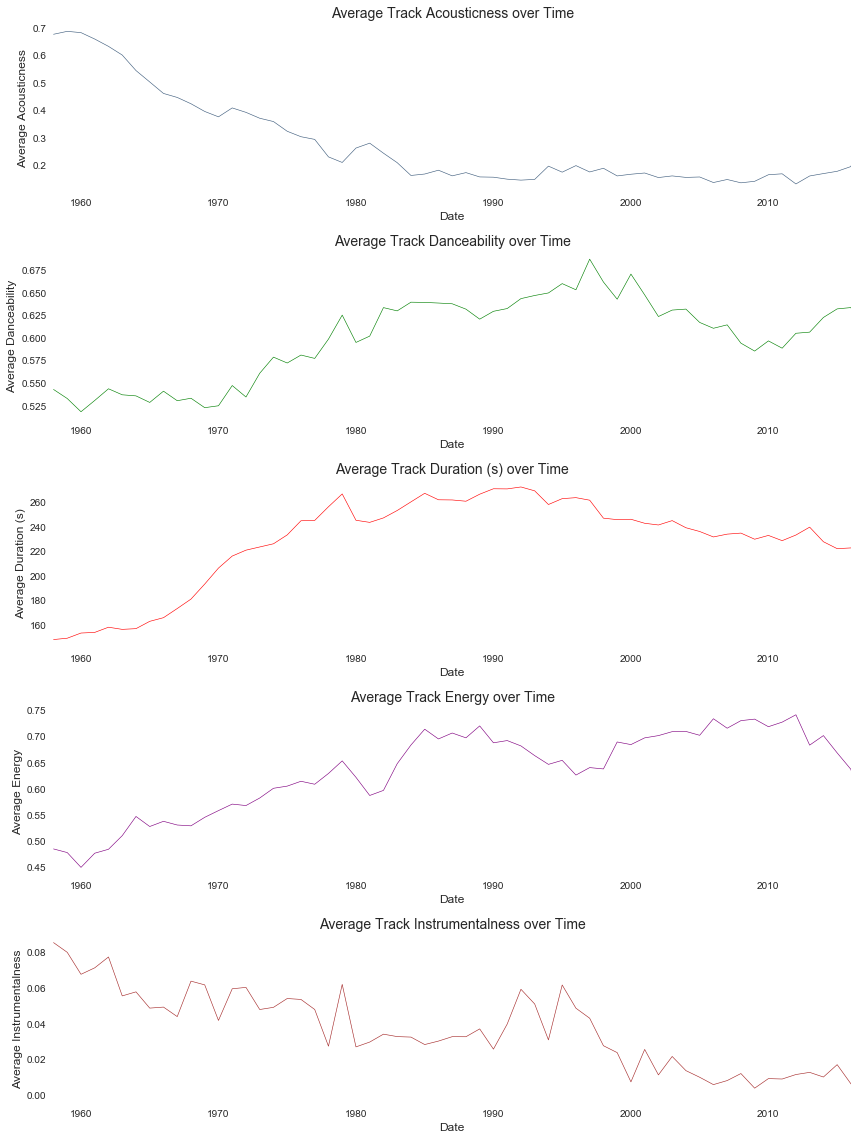

In [15]:
fig = plt.figure(figsize=(12, 16))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.plot(audio_means.year, audio_means.acousticness, color="#3F5D7D", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Acousticness', fontsize=12)
plt.title('Average Track Acousticness over Time', fontsize=14)
plt.xlim([1958,2016])

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.plot(audio_means.year,audio_means.danceability, color="green", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Danceability', fontsize=12)
plt.title('Average Track Danceability over Time', fontsize=14)
plt.xlim([1958,2016])

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.duration_ms/1000, color="red", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Duration (s)', fontsize=12)
plt.title('Average Track Duration (s) over Time', fontsize=14)
plt.xlim([1958,2016])


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.energy, color="purple", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Energy', fontsize=12)
plt.title('Average Track Energy over Time', fontsize=14)
plt.xlim([1958,2016])

axfive = plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.plot(audio_means.year,audio_means.instrumentalness, color="brown", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Instrumentalness', fontsize=12)
plt.title('Average Track Instrumentalness over Time', fontsize=14)
plt.xlim([1958,2016])

plt.tight_layout()
plt.show()


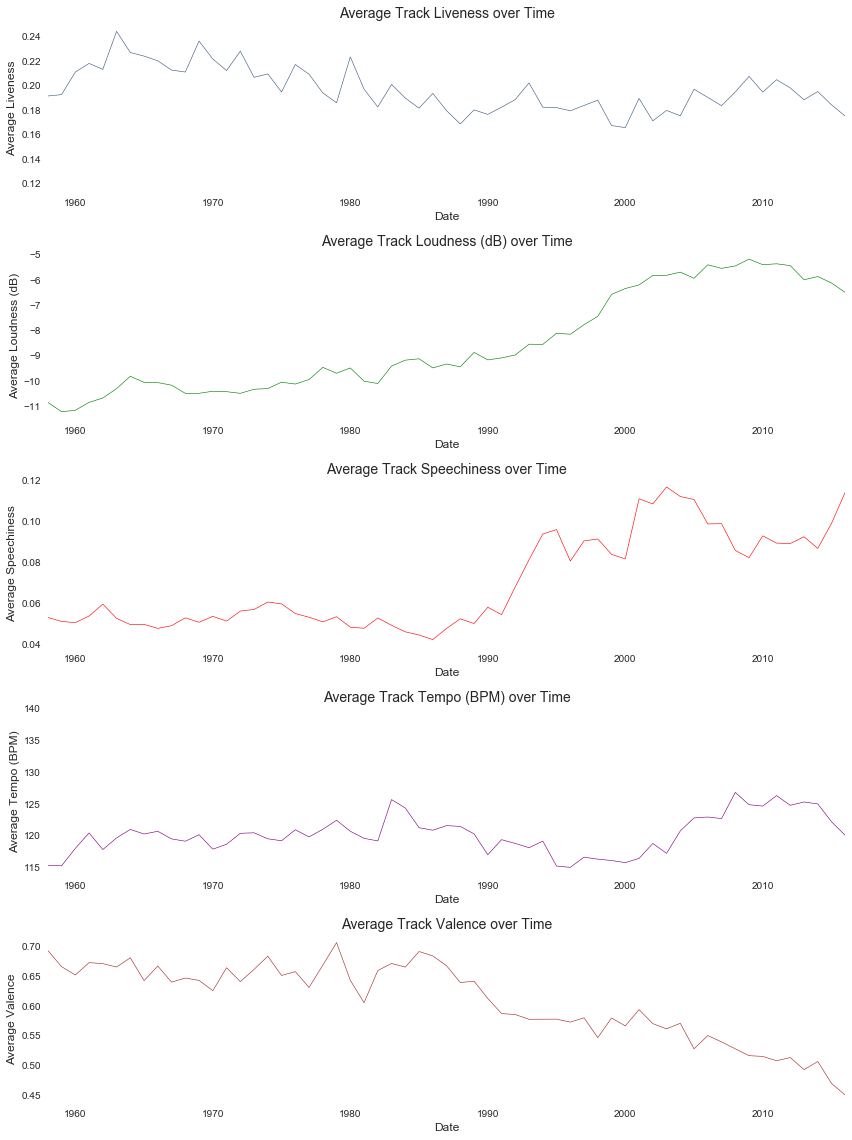

In [16]:
fig = plt.figure(figsize=(12, 16))

axone=plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()  
plt.plot(audio_means.year, audio_means.liveness, color="#3F5D7D", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Liveness', fontsize=12)
plt.title('Average Track Liveness over Time', fontsize=14)
plt.xlim([1958,2016])

axtwo=plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left() 
plt.plot(audio_means.year,audio_means.loudness, color="green", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Loudness (dB)', fontsize=12)
plt.title('Average Track Loudness (dB) over Time', fontsize=14)
plt.xlim([1958,2016])

axthree=plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.speechiness, color="red", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Speechiness', fontsize=12)
plt.title('Average Track Speechiness over Time', fontsize=14)
plt.xlim([1958,2016])


axfour=plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left() 
plt.plot(audio_means.year, audio_means.tempo, color="purple", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Tempo (BPM)', fontsize=12)
plt.title('Average Track Tempo (BPM) over Time', fontsize=14)
plt.xlim([1958,2016])

axfive = plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.plot(audio_means.year,audio_means.valence, color="brown", linewidth=0.6)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Valence', fontsize=12)
plt.title('Average Track Valence over Time', fontsize=14)
plt.xlim([1958,2016])

plt.tight_layout()
plt.show()

** Things of Note:**
It appears that the average acousticness, liveness, speechiness and valence of a song in the Billboard Top 100 have been decreasing over time, whereas danceability and energy have been increasing. We also that songs sunddenly became much longer in the seventies and the speechiness and loudness increased a lot in the nineties.

# 7. Lyrics Sentiment Analysis

** How many tracks have lyrics? From which sources? **

In [17]:
source_data=pd.DataFrame()
lyrics_count = len(lyrics_sub[lyrics_sub.source ==0])+len(lyrics_sub[lyrics_sub.source==1])
source_data = source_data.append({"source":"metrolyrics.com","lyrics count":lyrics_count},ignore_index=True)
lyrics_sources = ["songlyrics.com","lyricsmode.com","azlyrics.com","musixmatch.com"] 
for u in range(0,len(lyrics_sources)):
    lyrics_count = len(lyrics_sub[lyrics_sub.source ==u+2])
    source_data = source_data.append({"source":lyrics_sources[u],"lyrics count":lyrics_count},ignore_index=True)
no_lyrics= lyrics_sub[lyrics_sub.source.isnull()]
source_data=source_data.append({"source":"unavailable","lyrics count":len(no_lyrics)},ignore_index=True)
print("We have lyrics data for ",len(lyrics_sub[lyrics_sub.lyrics.notnull()])/len(lyrics_sub)*100,"% of the tracks in the Billboard Top 100.")
source_data

We have lyrics data for  82.6047556908801 % of the tracks in the Billboard Top 100.


,lyrics count,source
0,14527,metrolyrics.com
1,6594,songlyrics.com
2,1650,lyricsmode.com
3,6,azlyrics.com
4,12,musixmatch.com
5,4799,unavailable


** Note: The reason azlyrics.com and musixmatch.com have such low lyrics counts besides being the 4th and 5th choices is because our IP was blocked after only a few attempts. **

** We use the nltk python package to determine the sentiment for the lyrics of each song. **
The NLTK package assigns a positive, neutral and negative score to each sentence based on qualifiers and adjectives. We take the averages difference between the positive and negative score over each sentence to obtain a sentiment score for the lyrics which will be a value between -1 and 1.

In [18]:
# Measuring average sentiment
lyrics_not_null=lyrics_sub[lyrics_sub.lyrics.notnull()].reset_index()
sentiment_data=pd.DataFrame()
sid = SentimentIntensityAnalyzer()
for row in range(0,len(lyrics_not_null)):
    paragraph = lyrics_not_null.iloc[row,2]
    lines_list = tokenize.sent_tokenize(paragraph)
    compound_list=[]
    pos_list=[]
    neg_list=[]
    neut_list=[]
    for sentence in lines_list:
        ss = sid.polarity_scores(sentence)
        compound_list.append(ss["compound"])
        pos_list.append(ss["pos"])
        neg_list.append(ss["neg"])
        neut_list.append(ss["neu"])
        sent_negi=sum(neg_list)/len(neg_list)
        sent_posi=sum(pos_list)/len(pos_list)
        sent_neutral=sum(neut_list)/len(neut_list)
        sent_compound=sum(compound_list)/len(compound_list)
    add_frame = {"artist":lyrics_not_null.get_value(row,"artist"), "track":lyrics_not_null.get_value(row,"track"), "lyrics":lyrics_not_null.get_value(row,"lyrics"),"sent_compound":sent_compound, "sent_neutral":sent_neutral, "sent_positive":sent_posi,"sent_negative":sent_negi,  'source':lyrics_not_null.get_value(row,"source")}
    sentiment_data = sentiment_data.append(add_frame,ignore_index=True)

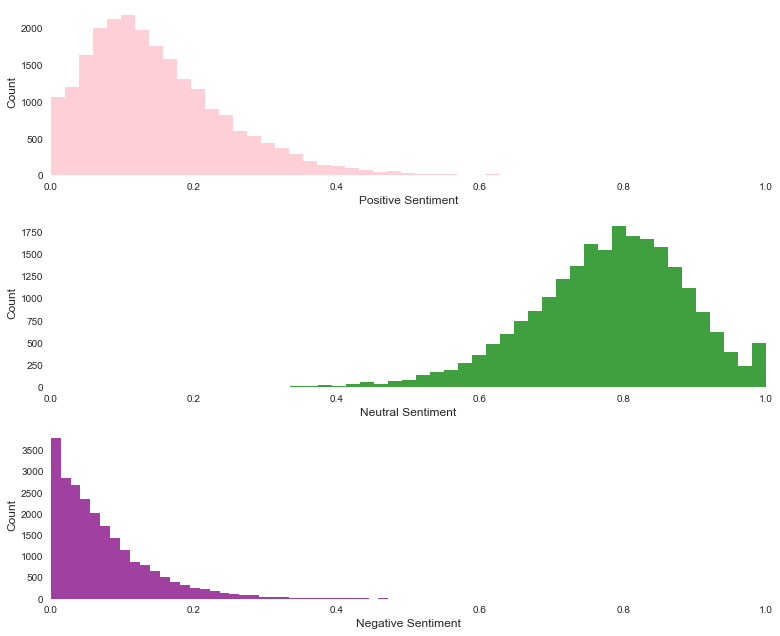

In [19]:
fig = plt.figure(figsize=(11, 9))
axone = plt.subplot(3,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()
plt.hist(sentiment_data.sent_positive, color="pink",bins=50,alpha=0.75)
plt.xlabel("Positive Sentiment", fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(0,1)

axtwo = plt.subplot(3,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left()
plt.hist(sentiment_data.sent_neutral, color="green",bins=50,alpha=0.75)
plt.xlabel("Neutral Sentiment", fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(0,1)

axthree = plt.subplot(3,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left()
plt.hist(sentiment_data.sent_negative, color="purple",bins=50,alpha=0.75)
plt.xlabel("Negative Sentiment", fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xlim(0,1)

plt.tight_layout()
plt.show()

** We now merge the sentiment data with the Billboard chart data. **

In [20]:
lyrics_with_sent=pd.merge(lyrics_sub,sentiment_data,how="outer",left_on=["track","artist","lyrics","source"],right_on=["track","artist","lyrics","source"])
merged_sent=pd.merge(big_dataset,lyrics_with_sent, how="outer",left_on=["artist","title","lyrics","source"],right_on=["artist","track","lyrics","source"])
all_data=merged_sent[["chartDate","title","artist","peakPos","lastPos","weeks","rank","change","acousticness","danceability","duration_ms","energy","instrumentalness","key","liveness","loudness","mode","speechiness","tempo","time_signature","valence","lyrics","source","sent_positive","sent_negative","sent_neutral","sent_compound"]]

** We create a year column for the data and group the data by year. We subset our data so that each song is represented by their w**

In [21]:
year = all_data.chartDate.replace({'-': ''}, regex=True)
year = year.apply(np.float)
year = year//10000
pd.set_option('precision', 0)
year=year.rename("year")
year_data=pd.concat([all_data,year],axis=1)
new_year = year_data.groupby(["title","artist"]).mean().reset_index()
new_year.year=new_year.year//1
audio_means_sub =new_year.groupby(["year"]).mean().reset_index()

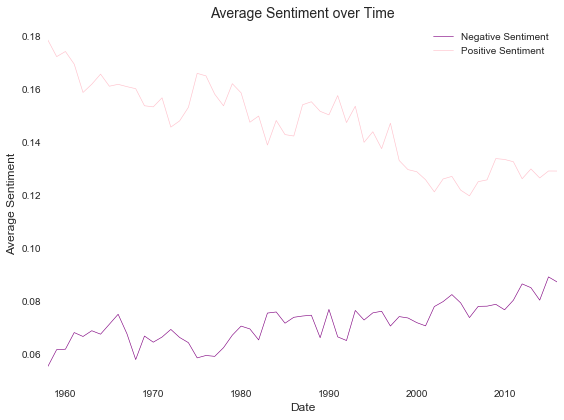

In [22]:
fig,axone=plt.subplots(figsize=(8, 6))
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()
plt.plot(audio_means_sub.year, audio_means_sub.sent_negative, color="purple", linewidth=0.6,label="Negative Sentiment")
plt.plot(audio_means_sub.year, audio_means_sub.sent_positive, color="pink", linewidth=0.6,label="Positive Sentiment")
#plt.plot(audio_means_sub.year, audio_means_sub.sent_neutral, color="green", linewidth=0.6,label="Neutral Sentiment")
plt.xlabel('Date', fontsize=12)
plt.ylabel('Average Sentiment', fontsize=12)
plt.title('Average Sentiment over Time', fontsize=14)
plt.xlim([1958,2016])
plt.legend()
plt.tight_layout()
plt.show()

** We see that the average negative sentiment has been increasing over time while average positive sentiment has been decreasing. **

## ** What is the most popular key? **

In [23]:
key_data=new_year.groupby(["key","mode"]).count().reset_index()

In [24]:
key_name_list = pd.Series(["Cm","C","C#m","C#","Dm","D","D#m","D#","Em","E","Fm","F","F#m","F#","Gm","G","G#m","G#","Am","A",'A#m',"A#","Bm","B"])
key_name_list=key_name_list.rename("key_name")
key_data=pd.concat([key_data,key_name_list],axis=1)

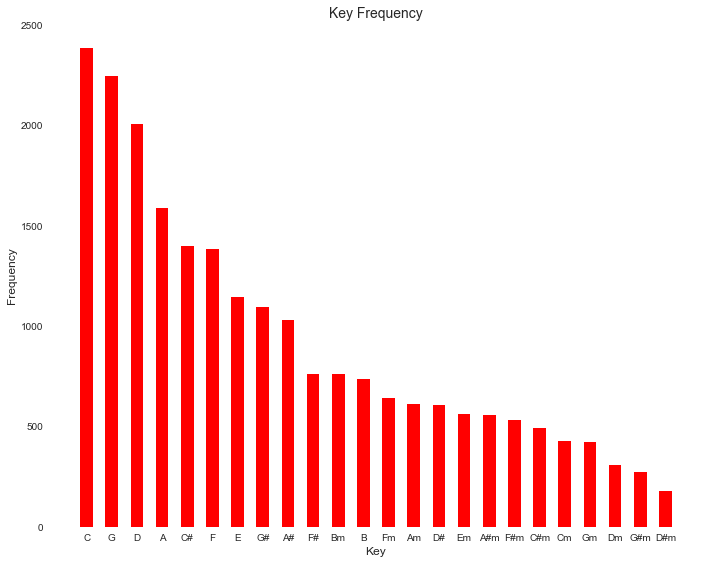

In [25]:
key_data=key_data.sort_values(by="year",ascending=False)
key_list=key_data.key_name
y_pos = np.arange(len(key_list))
fig,axone=plt.subplots(figsize=(10, 8))
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()
plt.bar(y_pos, key_data.year, width=0.5,color="red")
plt.xticks(y_pos,key_data.key_name)
plt.xlabel("Key", fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Key Frequency',fontsize=14)
plt.tight_layout()
plt.show()

** We see that most popular songs are in the key of C major closely followed by G major. **

** Note that this differs slightly from the analysis of all songs on Spotify which found that the most popular key is G major. ** 

https://insights.spotify.com/us/2015/05/06/most-popular-keys-on-spotify/ 

In [26]:
time_data=new_year.groupby(["time_signature"]).count().reset_index().sort_values(by="year",ascending=False)
time_data["percent"]=time_data.year/len(new_year[new_year.time_signature.notnull()])

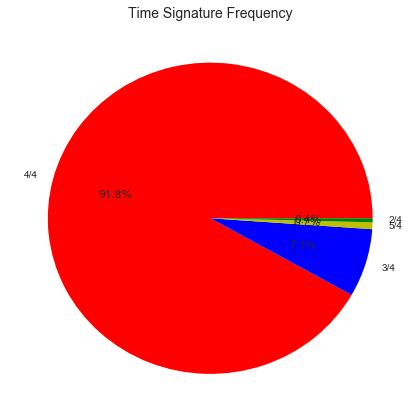

In [27]:
times = time_data.percent
colors = ['r','b' , 'y', 'g']
labels_time = ["4/4", "3/4", "5/4","2/4"]
fig, ax = plt.subplots(figsize=(6, 6))  # make the plot square
pie = ax.pie(times, colors=colors, labels=labels_time,autopct='%1.1f%%')
plt.title('Time Signature Frequency',fontsize=14)
plt.tight_layout()
plt.show()

** Here we see that the vast majority of songs on the Billboard Top 100 are written in 4/4 Time. **

## **Is D minor really the saddest of all keys? **
** Reference: ** https://www.youtube.com/watch?v=H7vk5keNbRc


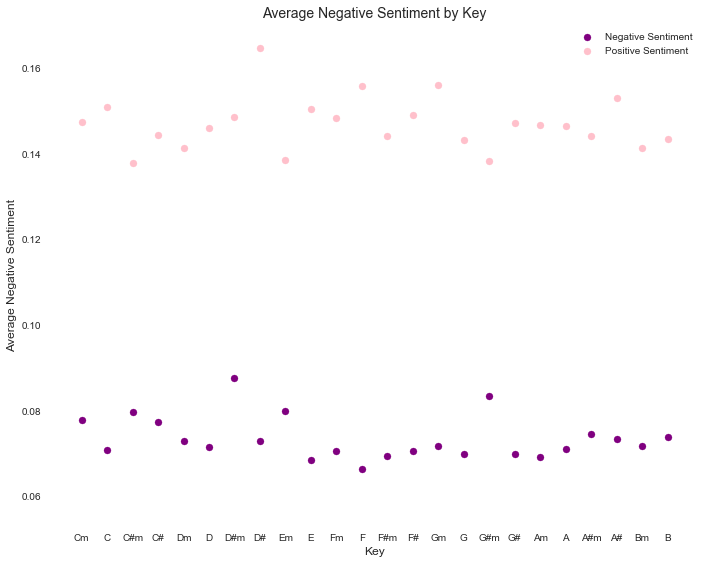

In [28]:
key_data_means=new_year.groupby(["key","mode"]).mean().reset_index()
key_data_means_list=pd.concat([key_data_means,key_name_list],axis=1)
#key_data_means_list=key_data_means_list.sort_values(by="sent_negative",ascending=False)
fig, axone = plt.subplots(figsize=(10, 8)) 
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()
plt.scatter(y_pos, key_data_means_list.sent_negative,color="purple",label="Negative Sentiment")
plt.scatter(y_pos, key_data_means_list.sent_positive,color="pink",label="Positive Sentiment")
plt.xticks(y_pos,key_data_means_list.key_name)
plt.xlabel("Key",fontsize=12)
plt.ylabel('Average Negative Sentiment',fontsize=12)
plt.title('Average Negative Sentiment by Key',fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

** As we expect, we see that the average negative sentiment is generally higer and the average positive sentiment generally lower for minor keys. Sadness is associated with negative sentiment and D#m rather than Dm is the most negative key. Note here that other emotions besides sadness are also counted towards a negative score. ** 

## ** How do the other variables relate to sentiment?**

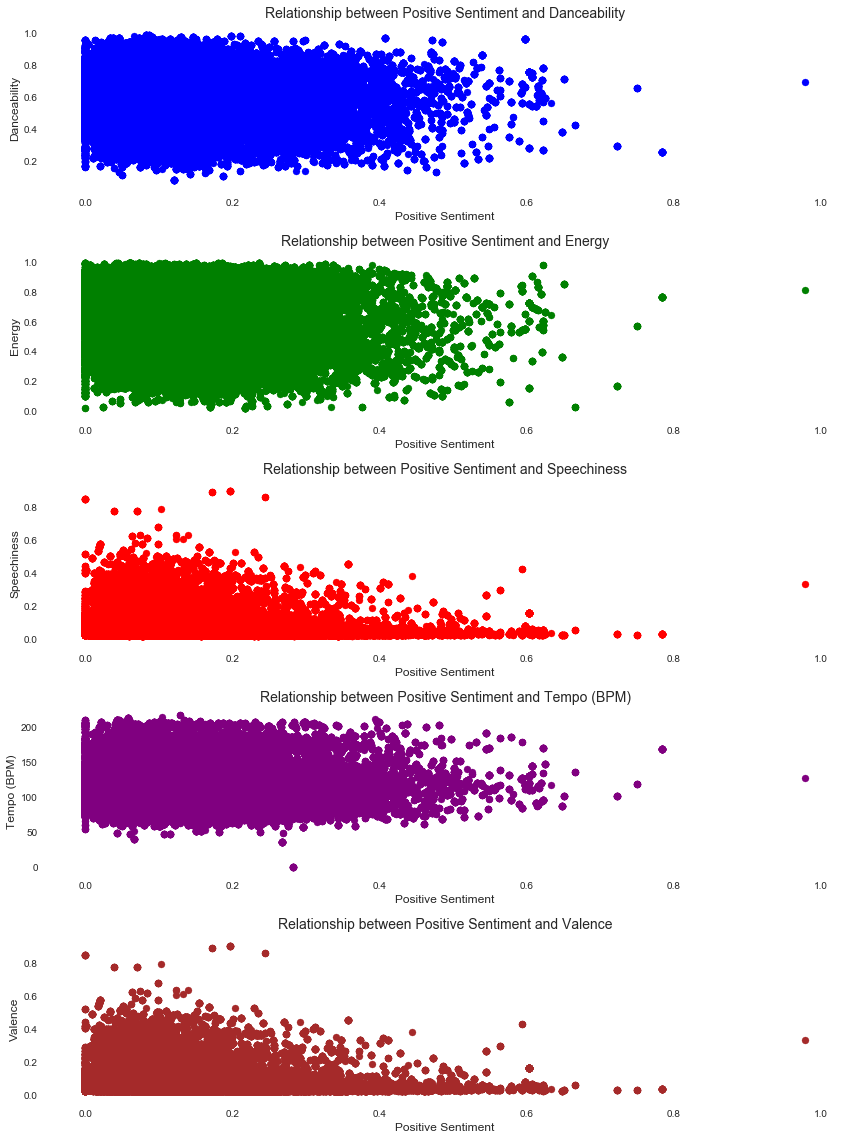

In [29]:
fig = plt.figure(figsize=(12, 16))
axone = plt.subplot(5,1,1)
axone.spines["top"].set_visible(False)  
axone.spines["right"].set_visible(False)
axone.set_facecolor('white')
axone.get_xaxis().tick_bottom()  
axone.get_yaxis().tick_left()
plt.scatter(all_data.sent_positive, all_data.danceability, color="blue")
plt.xlabel("Positive Sentiment",fontsize=12)
plt.ylabel("Danceability",fontsize=12)
plt.title("Relationship between Positive Sentiment and Danceability",fontsize=14)

axtwo = plt.subplot(5,1,2)
axtwo.spines["top"].set_visible(False)  
axtwo.spines["right"].set_visible(False)
axtwo.set_facecolor('white')
axtwo.get_xaxis().tick_bottom()  
axtwo.get_yaxis().tick_left()
plt.scatter(all_data.sent_positive, all_data.energy,color="green")
plt.xlabel("Positive Sentiment",fontsize=12)
plt.ylabel("Energy",fontsize=12)
plt.title("Relationship between Positive Sentiment and Energy",fontsize=14)

axthree = plt.subplot(5,1,3)
axthree.spines["top"].set_visible(False)  
axthree.spines["right"].set_visible(False)
axthree.set_facecolor('white')
axthree.get_xaxis().tick_bottom()  
axthree.get_yaxis().tick_left()
plt.scatter(all_data.sent_positive, all_data.speechiness,color="red")
plt.xlabel("Positive Sentiment",fontsize=12)
plt.ylabel("Speechiness",fontsize=12)
plt.title("Relationship between Positive Sentiment and Speechiness",fontsize=14)            
            
axfour = plt.subplot(5,1,4)
axfour.spines["top"].set_visible(False)  
axfour.spines["right"].set_visible(False)
axfour.set_facecolor('white')
axfour.get_xaxis().tick_bottom()  
axfour.get_yaxis().tick_left()
plt.scatter(all_data.sent_positive, all_data.tempo,color="purple")
plt.xlabel("Positive Sentiment",fontsize=12)
plt.ylabel("Tempo (BPM)",fontsize=12)
plt.title("Relationship between Positive Sentiment and Tempo (BPM)",fontsize=14)   
            
axfive = plt.subplot(5,1,5)
axfive.spines["top"].set_visible(False)  
axfive.spines["right"].set_visible(False)
axfive.set_facecolor('white')
axfive.get_xaxis().tick_bottom()  
axfive.get_yaxis().tick_left()
plt.scatter(all_data.sent_positive, all_data.speechiness,color="brown")
plt.xlabel("Positive Sentiment",fontsize=12)
plt.ylabel("Valence",fontsize=12)
plt.title("Relationship between Positive Sentiment and Valence",fontsize=14)   
            
plt.tight_layout()
plt.show()

** From this exploration we don't really see any relationship between Positive Sentiment and the other audio features **

## What are the most distinctive words each year?

** First we make a list of all the words in each song. **

In [30]:
from collections import Counter
lyrics_list=billboard_lyrics[billboard_lyrics.lyrics.notnull()].reset_index()
lower_limit =0
upper_limit =len(lyrics_list)
common_words = pd.DataFrame()
rgx = re.compile("(\w[\w']*\w|\w)")
for row in range(lower_limit,upper_limit):
    song_lyrics=lyrics_list.get_value(row,"lyrics")
    words = rgx.findall(song_lyrics)
    word_list = [word.lower() for word in words] 
    word_counts = Counter(word_list)
    add_frame = {"artist":lyrics_list.get_value(row,"artist"), "track":lyrics_list.get_value(row,"track"), "lyrics":song_lyrics,"common words":word_counts.most_common()}
    common_words = common_words.append(add_frame,ignore_index=True)

In [32]:
year = all_data.chartDate.replace({'-': ''}, regex=True)
year = year.apply(np.float)
year = year//10000
pd.set_option('precision', 0)
year=year.rename("year")
all_year=pd.concat([all_data,year],axis=1)
chart_year=all_year.groupby(["title","artist","lyrics","year"]).count().reset_index()
chart_sub=pd.merge(common_words,chart_year,left_on=["track","artist"],right_on=["title","artist"],how="outer")
chart_sub=chart_sub[["artist","common words","title","year"]].sort_values(by="year")

In [33]:
yearly_common_words=pd.DataFrame()
year_min=int(chart_sub.year.min())
year_max=int(chart_sub.year.max())
year_current=year_min
j=0
year_count = Counter()
while year_current<=year_max:
    year_check=chart_sub.iloc[j,3]
    if year_check==year_current:
        list_length=len(chart_sub.iloc[j,1])
        for i in range(0,list_length):
            year_count[chart_sub.iloc[j,1][i][0]] += 1        
    else:
        add_frame={"year":year_current,"common_words":year_count.most_common()}
        year_count = Counter()
        year_current+=1
        yearly_common_words=yearly_common_words.append(add_frame,ignore_index=True)
    j+=1

IndexError: single positional indexer is out-of-bounds

In [34]:
yearly_common_words.head(10)

,common_words,year
0,"[(the, 204), (and, 195), (i, 188), (you, 184),...",1958
1,"[(and, 393), (the, 385), (i, 373), (to, 353), ...",1959
2,"[(the, 432), (and, 416), (to, 396), (you, 391)...",1960
3,"[(the, 497), (to, 453), (i, 452), (you, 451), ...",1961
4,"[(the, 492), (and, 467), (i, 441), (you, 436),...",1962
5,"[(the, 471), (and, 455), (i, 443), (to, 443), ...",1963
6,"[(the, 501), (and, 496), (i, 495), (to, 487), ...",1964
7,"[(the, 536), (to, 515), (and, 510), (i, 500), ...",1965
8,"[(to, 527), (the, 521), (and, 515), (i, 508), ...",1966
9,"[(the, 544), (to, 518), (i, 504), (and, 498), ...",1967


## To do Log Likelihood: 
Steps: We have the word count for each year. Next we count the total word count for that year. Then for each word in that year we can get a rate. Next we get counts for all the years and the total word count for all the years. This gives us the population rate. Then we have enough information to follow the example: https://de.dariah.eu/tatom/feature_selection.html

In [ ]:
# 9. Predicting Song Popularity

Our goal is determine which of the features above can be used to predict performance of a song in the Top 100.